<a href="https://colab.research.google.com/github/yeedacoding/TensorFlow-DL/blob/main/ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# 패션 MNIST 데이터셋 확인

# 데이터 준비

from tensorflow import keras

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [18]:
print(train_input.shape, train_target.shape)

(60000, 28, 28) (60000,)


In [8]:
print(test_input.shape, test_target.shape)

(10000, 28, 28) (10000,)


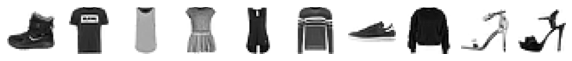

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 10, figsize=(10,10))

for i in range(10) :
  axs[i].imshow(train_input[i], cmap='gray_r')
  axs[i].axis('off')
plt.show()

In [10]:
print([train_target[i] for i in range(10)])

[9, 0, 0, 3, 0, 2, 7, 2, 5, 5]


### 레이블

패션 MNIST 타깃은 0~9까지의 숫자 레이블로 구성됨
- 티셔츠 = 0
- 바지 = 1
- 스웨터 = 2
- 드레스 = 3
- 코트 = 4
- 샌달 = 5
- 셔츠 = 6
- 스니커즈 = 7
- 가방 = 8
- 앵클 부츠 = 9

In [14]:
# 각 레이블 당 샘플 개수 확인

import numpy as np

print(np.unique(train_target, return_counts = True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))


## 로지스틱 회귀로 패션 아이템 분류하기

- 훈련 샘플은 60,000개이므로 전체 샘플을 한꺼번에 꺼내어 훈련하는 것은 비효율적
- 확률적 경사 하강법으로 샘플을 하나씩 꺼내어 모델을 훈련하는 방법이 더 효율적
- SGDClassifier 클래스의 loss 매개변수를 'log'로 지정하여 로지스틱 손실 함수를 최소화하는 확률적 경사 하강법 모델 만들기


In [19]:
# 패션 MNIST의 샘플의 각 픽셀은 0~255 사이의 정숫값을 가지므로 255로 나누어 0~1사이의 값으로 정규화
# SGDClassifier는 2차원 입력을 다루지 못하기 때문에 각 샘플을 1차원 배열로 만들기

train_scaled = train_input / 255
train_scaled = train_scaled.reshape(-1, 28*28)

print(train_scaled.shape)

(60000, 784)


In [21]:
# 교차검증으로 성능을 확인해보기

from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier

sc = SGDClassifier(loss = 'log', max_iter = 5, random_state = 42)
scores = cross_validate(sc, train_scaled, train_target, n_jobs = -1)

print(np.mean(scores['test_score']))

0.8195666666666668


#### scikit learn에서 공부했던 생선 모델을 활용한 로지스틱 회귀 공식

z = a * (Weight) + b * (Length) + c * (Diagonal) + d * (Height) + e * (Width) + f

- 위의 식을 패션 MNIST 데이터에 맞게 변형하면

z_티셔츠 = w1 * (픽셀 1) + w2 * (픽셀 2) + w3 * (픽셀 3) + ... + w784 * (픽셀 784) + b


- 총 784개의 픽셀, 즉 특성으로 이루어져 있으므로 긴 선형 방정식이 완성됨
- w = 가중치(계수, 생선모델에서의 a,b,c...)
- b = 절편

- 바지에 대한 선형 방정식

z_티셔츠 = w1 * (픽셀 1) + w2 * (픽셀 2) + w3 * (픽셀 3) + ... + w784 * (픽셀 784) + b

- 티셔츠에 대한 선형 방정식과 매우 비슷함
- 동일한 784개의 픽셀값은 그대로 사용하되
- 티셔츠와는 다른 가중치(w)와 절편(b) 값을 사용해야함
- 따라서 총 10개의 선형 방정식(패션 MNIST의 클래스가 10개 이므로)은 각기 다른 모델 파라미터(가중치와 절편) 값을 가짐
- SGDClassifier 모델은 클래스(티셔츠, 바지,...)를 잘 구분하기 위해 10개의 선형 방정식이 적절한 모델 파라미터(가중치와 절편)를 찾을 수 있게 해줌
- z_티셔츠, z_바지와 같이 10개의 클래스에 대한 선형 방정식을 모두 계산한 다음에는 소프트맥스 함수(다중 분류 문제이기 때문에)를 통과하여 각 클래스에 대한 확률을 얻을 수 있음

# 패션 MNIST 아이템 분류를 인경 신경망으로 구현하기

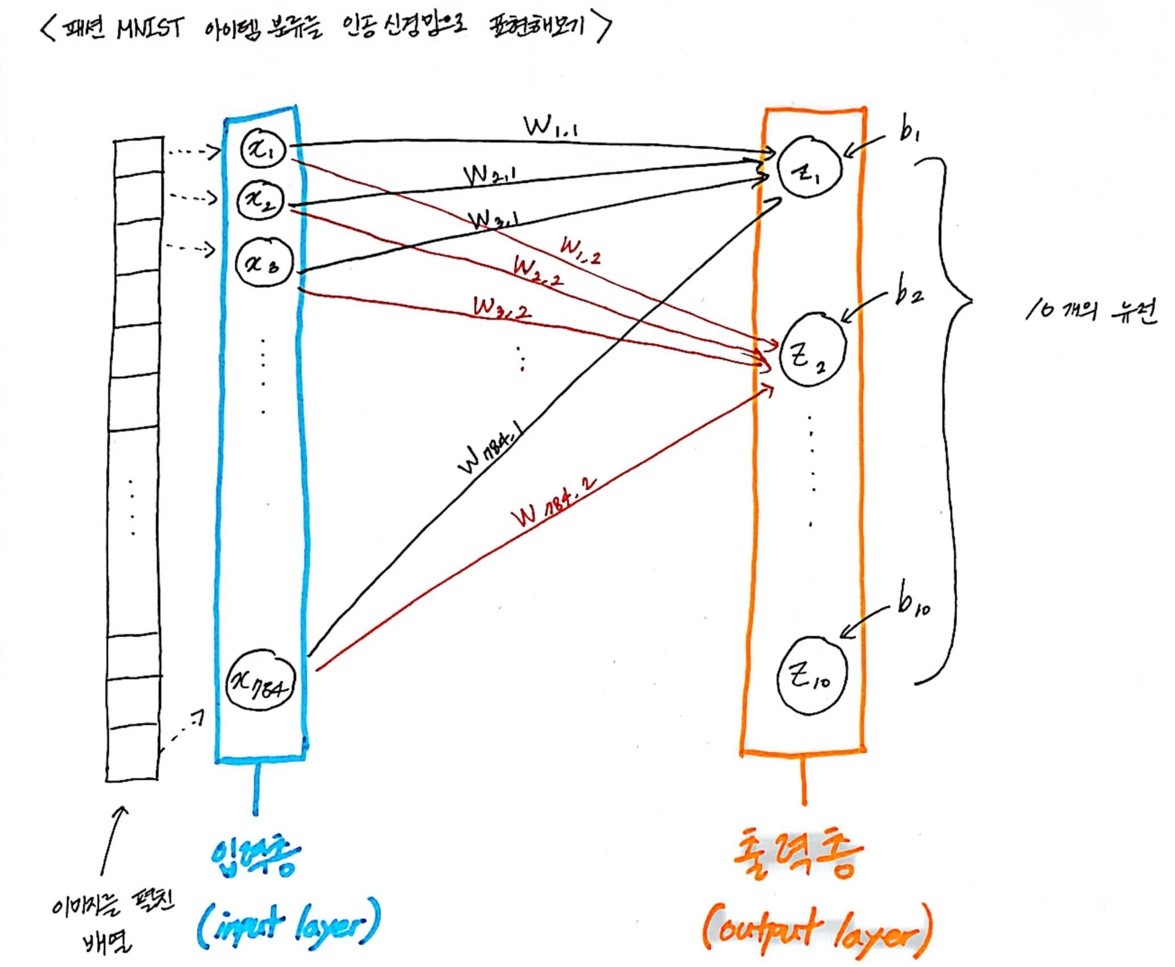

- 로지스틱 회귀로 분류한 모델과 구조가 매우 비슷
- z1 ~ z10 = 클래스(티셔츠, 바지,..)
- x1 ~ x784 = 픽셀값
- b1 ~ b10 = 절편
- 입력층(input layer) = x1 ~ x784까지
- 출력층(output layer) = z1 ~ z10까지
- 출력층을 바탕으로 클래스를 예측하기 때문에 신경망의 최종 값을 만든다는 의미에서 출력층이라고 부름
- 뉴런 = 각 z 값을 계산하는 단위 (선형 계산이 일어남)
- 입력층은 픽셀값 자체이고 특별한 계산 수행을 하지 않음
- z1을 만들기 위해 x1에 가중치 w1,1을 곱하고 절편 b1을 더함

#### 딥러닝 라이브러리가 다른 머신러닝 라이브러리와 다른 점

- 딥러닝 라이브러리는 그래픽 처리 장치인 GPU를 사용하여 인공신경망 훈련
- GPU -> 벡터와 행렬 연산에 매우 최적화 되어 있음 -> 빠르게 훈련 가능

# 인공신경망으로 모델 만들기

In [22]:
# 앞서 로지스틱 회귀에서 만든 훈련 데이터 train_scaled, train_target 사용
# 로지스틱 회귀에서는 교차 검증을 사용해 모델을 평가
# 인공 신경망에서는 교차 검증을 잘 사용하지 않고 검증 세트를 별도로 덜어내어 사용

# 검증 세트 나누기

from sklearn.model_selection import train_test_split

# 훈련 세트에서 20%를 검증 세트로 덜어내기
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size = 0.2, random_state = 42)

In [23]:
print(train_scaled.shape, train_target.shape)

(48000, 784) (48000,)


In [24]:
print(val_scaled.shape, val_target.shape)

(12000, 784) (12000,)


- 훈련 세트의 60,000개의 샘플 중 12,000개가 검증 세트로 분리되었음
1. 훈련 세트(train_scaled, train_target)로 모델 만들기
2. 검증 세트(val_scaled, val_target)로 훈련한 모델 평가하기

## 케라스의 레이어(keras.layers)

- keras.layers 패키지 안에는 다양한 층이 준비되어 있음
- 가장 기본이 되는 층은 밀집층(dense layer)
- 784개의 픽셀과 10개의 뉴런(출력층)이 모두 연결됨 = 완전 연결층(fully connected layer)
- 케라스의 Dense 클래스를 사용해 밀집층을 만들어보기
- 케라스의 Dense 클래스에 필요한 매개변수는 뉴런 개수, 뉴런의 출력에 적용할 함수, 입력의 크기

In [30]:
# 밀집층 만들기

dense = keras.layers.Dense(10, activation = 'softmax', input_shape = (784, ))

- 첫 번째 매개변수 = 뉴런의 개수(10개)
- activation = 뉴런의 출력에 적용할 함수(10개의 뉴런에서 출력되는 값을 확률로 바꾸기 위해서 소프트맥스 함수 사용, 이진 분류라면 activation='sigmoid')
- input_shape = 입력층의 크기 (10개의 뉴런이 각각 몇 개의 입력을 받는지 튜플로 지정)

#### 활성화 함수
소프트맥스와 같이 뉴런의 선형 방정식 계산 결과에 적용되는 함수를 활성화 함수(activation function)이라고 한다.

In [31]:
# 밀집층을 가진 신경망 모델 만들기
# 케라스의 Sequential 클래스 사용
# 여기서 만든 model 객체가 바로 신경망 모델

model = keras.Sequential(dense)

# 인공 신경망으로 패션 아이템 분류하기

- 케라스 모델은 훈련하기 전에 설정 단계가 있음
- 이런 설정을 model 객체의 compile() 메서드에서 수행
- 반드시 지정해야 할 것은 "손실함수의 종류"
- 그 다음 훈련 과정에서 계산 하고 싶은 측정값을 지정

In [32]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

## compile() 메서드의 매개변수 확인해보기

1. loss = 'sparse_categorical_crossentropy'
2. metrics = 'accuracy'

### 1. sparse_categorical_crossentropy

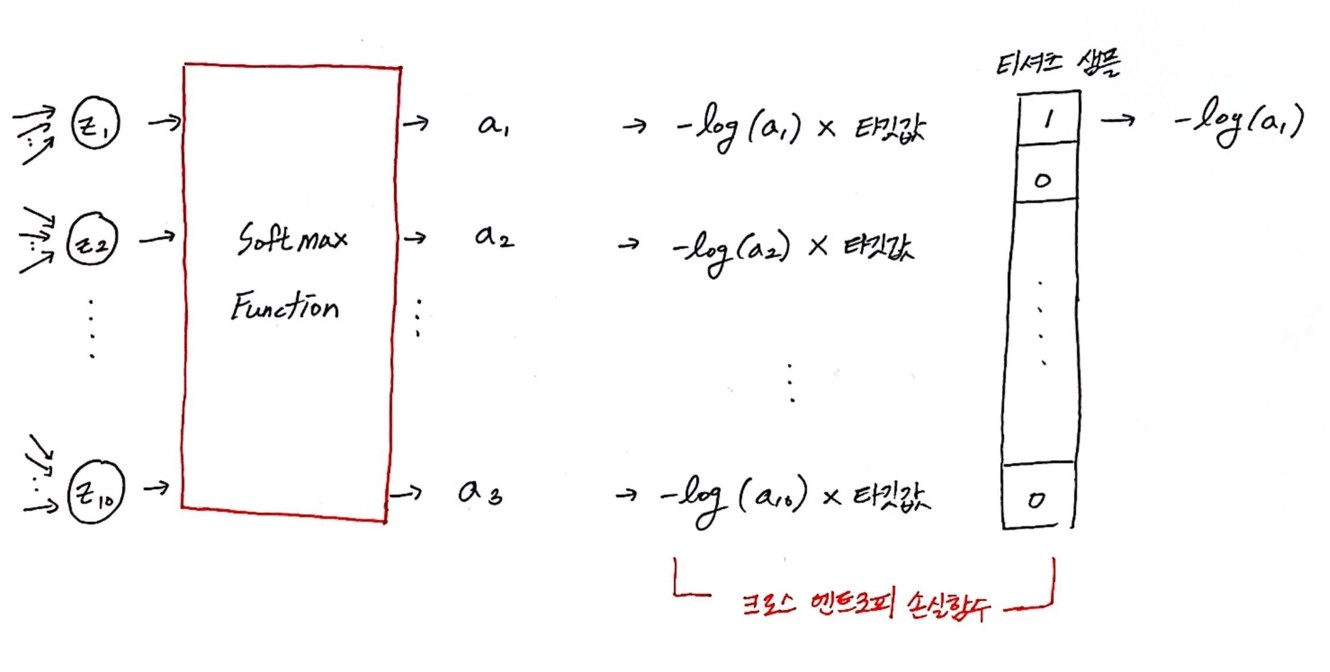

- 출력층(z1 ~ z10)은 10개의 뉴런이 있고 소프트맥스 함수를 통해 10개의 클래스에 대한 확률을 출력함
- 첫 번째 뉴런은 티셔츠일 확률, 두 번째 뉴런은 바지일 확률을 출럭
- 이진 분류와 달리 각 클래스에 대한 확률이 모두 출력되기 때문에 타깃에 해당하는 확률만 남겨 놓기 위해서 나머지 확률에는 모두 0을 곱한다
- 예를 들어, 샘플이 티셔츠일 경우 첫 번째 뉴런의 활성화 함수 출력인 a1에 크로스 엔트로피 손실함수를 적용하고 나머지 활성화 함수 출력 a2 ~ a10까지는 모두 0으로 만든다
- 이렇게 하기 위해서 티셔츠 샘플의 타깃값은 첫 번째 원소만 1, 나머지는 모두 0인 배열로 만들 수 있음([1,0,0,0,0,0,0,0,0,0])
- 이 배열과 출력층의 활성화 값의 배열과 곱하면 된다
- [a1, a2, a3, a4, a5, a6, a7, a8, a9, a10] * [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
- 원-핫 인코딩(one-hot encoding) : 타깃값을 해당 클래스만 1이고 나머지는 모두 0인 배열로 만드는 것
- 다중 분류에서 크로스 엔트로피 손실 함수를 사용하려면 타깃값은 정수로 된 0, 1, 2와 같은 값을 원-핫 인코딩으로 변환해야함

In [25]:
# 패션 MNIST 타깃값 확인해보기

print(train_target[:10])

[7 3 5 8 6 9 3 3 9 9]


- tensorflow에서는 정수로 된 타깃값을 원-핫 인코딩으로 바꾸지 않고 그냥 사용할 수 있음
- 정수로 된 타깃값을 원-핫 인코딩으로 바꾸지 않고 바로 사용해 크로스 엔트로피 손실을 계산하는 것이 바로 "sparse_categorical_crossentropy"
- 만약 원-핫 인코딩으로 타깃값을 준비했다면 loss='categorical_crossentropy'로 지정

### 2. metrics = 'accuracy'

- 케라스는 모델이 훈련할 때 기본으로 에포크마다 '손실 값'을 출력해준다
- 여기에 정확도를 함께 출력하기 위해 metrics='accuracy'를 지정

## 모델 훈련하기

- fit() 메서드 사용
- 에포크 횟수를 epochs 매개변수로 지정

In [33]:
model.fit(train_scaled, train_target, epochs = 5)

Epoch 1/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.6107 - accuracy: 0.7909
Epoch 2/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4787 - accuracy: 0.8393
Epoch 3/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4557 - accuracy: 0.8476
Epoch 4/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4441 - accuracy: 0.8529
Epoch 5/5
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4367 - accuracy: 0.8551


## 모델 평가하기

- 케라스에서 모델의 성능을 평가하는 메서드는 'evaluate()'

In [34]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 1ms/step - loss: 0.4389 - accuracy: 0.8543


[0.43886446952819824, 0.8543333411216736]

# 정리
## 사이킷런의 SGDClassifier vs 케라스의 Sequential

1. 사이킷런 모델
- 모델 : sc = SGDClassifier(loss='log', max_iter = 5)
- 훈련 : sc.fit(train_scaled, train_target)
- 평가 : sc.score(val_scaled, val_target)

2. 케라스 모델
- 층 생성 : dense = keras.layers.Dense(10, activation = 'softmax', input_shape(784, ))
- 모델 : model = keras.Sequential(dense)
- 훈련 준비 : model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
- 훈련 : model.fit(train_scaled, train_target)
- 평가 : model.evaluate(val_scaled, val_target)

In [ ]:
# 전체 코드

################################################################################
# 데이터 준비

from tensorflow import keras

(train_input, train_target), (test_input, test_target) = keras.datasets.fashion_mnist.load_data()


################################################################################
# 로지스틱 회귀로 패션 아이템 분류하기

# 패션 MNIST의 샘플의 각 픽셀은 0~255 사이의 정숫값을 가지므로 255로 나누어 0~1사이의 값으로 정규화
# SGDClassifier는 2차원 입력을 다루지 못하기 때문에 각 샘플을 1차원 배열로 만들기

train_scaled = train_input / 255
train_scaled = train_scaled.reshape(-1, 28*28)

print(train_scaled.shape)

# 교차검증으로 성능을 확인해보기

from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier

sc = SGDClassifier(loss = 'log', max_iter = 5, random_state = 42)
scores = cross_validate(sc, train_scaled, train_target, n_jobs = -1)

print(np.mean(scores['test_score']))



################################################################################
################################################################################
# 인공 신경망으로 모델 만들기

# 앞서 로지스틱 회귀에서 만든 훈련 데이터 train_scaled, train_target 사용
# 로지스틱 회귀에서는 교차 검증을 사용해 모델을 평가
# 인공 신경망에서는 교차 검증을 잘 사용하지 않고 검증 세트를 별도로 덜어내어 사용

# 검증 세트 나누기

from sklearn.model_selection import train_test_split

# 훈련 세트에서 20%를 검증 세트로 덜어내기
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size = 0.2, random_state = 42)


# 밀집층 만들기

dense = keras.layers.Dense(10, activation = 'softmax', input_shape = (784, ))

# 밀집층을 가진 신경망 모델 만들기
# 케라스의 Sequential 클래스 사용
# 여기서 만든 model 객체가 바로 신경망 모델

model = keras.Sequential(dense)

################################################################################
# 인공 신경망으로 패션 아이템 분류하기

# 훈련 준비
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

# 훈련
model.fit(train_scaled, train_target, epochs = 5)

# 평가
model.evaluate(val_scaled, val_target)